In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import casadi as ca
from pytope import Polytope
from matplotlib.animation import FuncAnimation
from scipy.spatial import ConvexHull
from scipy.stats import multivariate_normal
from tqdm import tqdm

In [6]:
simulation_time = 400
x_low = 0
x_up = 100
y_low = 0
y_up = 5

road_vertices = np.array([
    [x_low, y_low],
    [x_low, y_up],
    [x_up, y_up],
    [x_up, y_low],
])

Drive_Area = Polytope(road_vertices)
A_road = Drive_Area.A
b_road = Drive_Area.b

In [3]:
class SV_controller(): #without risk
    def __init__(self, Param):

        self.SV_Acc = Param["init_acc"]
        self.N = Param["N"] 
        self.T = Param["T"] 
        self.radius = Param["radius"]
        self.num_vertices = Param["num_vertices"]
        self.l_f = Param["l_f"] 
        self.l_r = Param["l_r"] 
        self.l_veh = Param["l_veh"] 
        self.w_veh = Param["w_veh"] 
        self.DEV = Param["DEV"]
        self.Q1 = Param["Q1"]
        self.Q2 = Param["Q2"]
        self.Q3 = Param["Q3"]
        self.Q4 = Param["Q4"]
        self.Q5 = Param["Q5"]
        self.Q6 = Param["Q6"]
        self.Q7 = Param["Q7"]
        self.d_min = Param["d_min"]
        self.A_road = Param["A_road"]
        self.b_road = Param["b_road"]
        self.v_low = Param["v_low"]
        self.v_up = Param["v_up"]
        self.acc_low = Param["acc_low"]
        self.acc_up = Param["acc_up"]
        self.delta_low = Param["delta_low"]
        self.delta_up = Param["delta_up"]
        self.RefSpeed = Param["RefSpeed"]
        self.RefPos = Param["RefPos"]
        
        self.U_SV_Poly = self.Generate_Polytope(self.radius,self.num_vertices)
        self.H = self.U_SV_Poly.A 
        self.h = self.U_SV_Poly.b 
        self.nv = np.size(self.H, 0)
        self.nu = np.size(self.H, 1)
        for i in range(self.nv):
            self.H[i,:] /= self.h[i]
        self.h = np.ones_like(self.h)
        self.N_Sam = self.SV_Acc.shape[1]

        self.LP = self.OR_LP()
        self.theta_pre,self.y_pre,self.rho_pre = self.LP(np.array([[0],[0]]),np.zeros((self.nu,1)),0.1*np.ones((self.nv,1)))
        self.MPC = self.MPCFormulation()


    def Return(self,SV_Acc_new, SV_Pos_new, SV_Vel_new, tmp , current_x_EV):

        RefSpeed = self.RefSpeed
        RefPos = self.RefPos
        G, g, Occupancy_SV = self.ReachableSet(SV_Acc_new, SV_Pos_new, SV_Vel_new)
        RefXPos = RefPos[0]
        RefYPos = RefPos[1]
        RefPhi  = RefPos[2]
        Trajectory_k, Control_k, J_k, s_k = self.MPC(0.5*G, 0.5*g, current_x_EV, RefSpeed, RefXPos, RefYPos, RefPhi)
        Trajectory_k = Trajectory_k.full( )
        Control_k = Control_k.full( )

        return Control_k[:, 0], Trajectory_k, J_k.full( ), Occupancy_SV, tmp


    def ReachableSet(self,SV_Acc_new, SV_Pos_new, SV_Vel_new):

        self.U_Hat_Poly = self.OR(SV_Acc_new)

        A_SV = np.array([[1, self.T, 0, 0], [0, 1, 0, 0], [0, 0, 1, self.T], [0, 0, 0, 1]])
        B_SV = np.array([[0.5*self.T**2, 0], [self.T, 0], [0, 0.5*self.T**2], [0, self.T]])
        BU = B_SV*self.U_Hat_Poly
        Reachable_Set = list()
        Occupancy_SV = list()
        x_t = np.array([SV_Pos_new[0], SV_Vel_new[0], SV_Pos_new[1], SV_Vel_new[1]])
        Reachable_Set.append(x_t)
        G = np.zeros((4, 2*self.N)) 
        g = np.zeros((4, self.N))

        for t in range(1,self.N+1):
            if t == 1:
                reachable_set_t = (A_SV@Reachable_Set[t - 1] + BU) 
            else:
                reachable_set_t = (A_SV*Reachable_Set[t - 1] + BU) 
            
            vertex = reachable_set_t.V
            vertex_xy = np.delete(vertex, [1, 3], axis = 1)
            occupancy_SV_t = Polytope(vertex_xy) 
            occupancy_SV_t.minimize_V_rep( )
            temp_poly   = occupancy_SV_t
            G[:, 2*t-2:2*t] = temp_poly.A
            g[:, t-1]       = temp_poly.b.reshape(4, )

            Occupancy_SV.append(temp_poly)
            Reachable_Set.append(reachable_set_t)

        return G, g, Occupancy_SV
    

    def MPCFormulation(self):

        d_min = self.d_min          #minimum distance
        N = self.N                  #prediction length
        DEV = self.DEV              #dimension
        T = self.T                  #sampling interval
        Q1 = self.Q1                #weighting matrix steering wheel angle
        Q2 = self.Q2                #weighting matrix longitudinal jerk
        Q3 = self.Q3                #weighting matrix long. velocity error
        Q4 = self.Q4                #weighting matrix long. pos. error
        Q5 = self.Q5                #weighting matrix lat. pos. error
        Q6 = self.Q6                #weighting matrix heading. error
        Q7 = self.Q7                #weighting matrix slack variable
        A_road = self.A_road        #driving area.A
        b_road = self.b_road        #driving area.B
        v_up = self.v_up 
        v_low = self.v_low
        acc_low = self.acc_low 
        acc_up = self.acc_up 
        delta_low = self.delta_low 
        delta_up = self.delta_up

        opti = ca.Opti( )
        X = opti.variable(DEV, N + 1)
        U = opti.variable(2, N)
        delta = U[0, :]
        eta   = U[1, :]
        lam = opti.variable(4, N)
        s   = opti.variable(N, 1)

        G = opti.parameter(4, 2*N)
        g = opti.parameter(4, N)
        Initial = opti.parameter(DEV, 1)
        v_ref = opti.parameter( )
        x_ref = opti.parameter( )
        y_ref = opti.parameter( )
        phi_ref = opti.parameter( )

        opti.subject_to(X[:, 0] == Initial)
        for k in range(N):
            k1 = self.vehicle_model(X[:, k], delta[k], eta[k])
            k2 = self.vehicle_model(X[:, k] + T/2*k1, delta[k], eta[k])
            k3 = self.vehicle_model(X[:, k] + T/2*k2, delta[k], eta[k])
            k4 = self.vehicle_model(X[:, k] + T*k3, delta[k], eta[k])
            x_next = X[:, k] + T/6 * (k1 + 2*k2 + 2*k3 + k4)
            opti.subject_to(X[:, k + 1] == x_next) 
        x = X[0, 1::]
        y = X[1, 1::]
        phi = X[2, 1::]
        v = X[3, 1::]
        a = X[4, 1::]
        phi_error = phi[-1] - phi_ref
        v_error = v[-1] - v_ref # longitudinal speed error
        x_error = x[-1] - x_ref # longitudinal position error
        y_error = y[-1] - y_ref # lateral position error

        for k in range(N):
            p_point = X[0:2, k + 1]
            
            G_point = G[:, 2*k:2*k + 2]
            g_point = g[:, k]
            temp = G_point.T@lam[:, k]
            opti.subject_to((G_point@ca.reshape(p_point,2,1) - g_point).T@lam[:, k] >= d_min - s[k])
            opti.subject_to(temp[0]**2 + temp[1]**2 == 1)
            opti.subject_to(0 <= lam[:, k])
            opti.subject_to(A_road@ca.reshape(p_point,2,1) <= b_road)

        #opti.subject_to(opti.bounded(0, s, 4))
        opti.subject_to(opti.bounded(v_low, v, v_up))
        opti.subject_to(opti.bounded(acc_low, a, acc_up))
        opti.subject_to(opti.bounded(delta_low, delta, delta_up))
        
        J = delta@Q1@delta.T + eta@Q2@eta.T + Q3*v_error@v_error.T + Q4*x_error@x_error.T + Q5*y_error@y_error.T + Q6*phi_error@phi_error.T + Q7*s.T@s
        opti.minimize(J)
        
        opts = {"ipopt.print_level": 0, "print_time": False} #"ipopt.linear_solver": "ma57",
        opti.solver('ipopt', opts)

        return opti.to_function('g', [G, g, Initial, v_ref, x_ref, y_ref, phi_ref], [X, U, J, s])
    

    def  vehicle_model(self, w, delta, eta):

        l_f = self.l_f
        l_r = self.l_r
        
        beta = np.arctan(l_r/(l_f + l_r)*np.tan(delta))
        x_dot   = w[3]*np.cos(w[2] + beta) 
        y_dot   = w[3]*np.sin(w[2] + beta)
        phi_dot = w[3]/(l_r)*np.sin(beta)
        v_dot = w[4]
        a_dot = eta
        
        return ca.vertcat(x_dot, y_dot, phi_dot, v_dot, a_dot)
    

    def Generate_Polytope(self, radius, num_vertices):

        if num_vertices != 4:
            angles = np.linspace(0, 2 * np.pi, num_vertices, endpoint=False)
            x_coords = radius * np.cos(angles)
            y_coords = radius * np.sin(angles)

            vertices = np.column_stack((x_coords, y_coords))
            U_SV_Poly = Polytope(vertices)

            return U_SV_Poly
        else:
            low_bound_control  = (-radius, -radius)
            up_bound_control   = (radius,   radius)
            U_SV_Poly = Polytope(lb = low_bound_control, ub = up_bound_control)
            return U_SV_Poly  


    def OR_LP(self):

        H = self.H
        nv = self.nv
        nu = self.nu

        opti = ca.Opti()

        rho = opti.variable()
        theta = opti.variable(nv,1)
        y = opti.variable(nu,1)

        samples = opti.parameter(nu, 1)
        y_pre = opti.parameter(nu,1)
        theta_pre = opti.parameter(nv,1)

        opti.minimize(rho + np.ones((1, nv))@theta)

        opti.subject_to(H @ samples-H @ y <= theta)
        opti.subject_to(H @ y_pre + theta_pre <= H @ y + theta)
        opti.subject_to(H @ y <= (1 - rho)@np.ones((nv,1)))
        opti.subject_to(opti.bounded(0, theta, 1))
        opti.subject_to(opti.bounded(0, rho, 1))
        opti.subject_to(theta <= rho@np.ones((nv,1)))

        opts = {"ipopt.print_level": 0, "print_time": False}
        opti.solver('ipopt', opts)

        return opti.to_function('f', [samples, y_pre, theta_pre], [theta, y, rho])    
    

    def OR(self,SV_Acc_new):

        self.theta_pre,self.y_pre,self.rho_pre = self.LP(SV_Acc_new,self.y_pre,self.theta_pre)
        U_Hat_Poly = Polytope(self.H, self.theta_pre)+self.y_pre

        return U_Hat_Poly
    

    def Plot_Polytope(self):

        plt.figure()
        self.U_SV_Poly.plot(color = 'b', alpha = 0.3)
        self.U_Hat_Poly.plot(color = 'r', alpha = 0.3)

        plt.scatter(self.SV_Acc[0,:],self.SV_Acc[1,:],marker='x',color = 'black')
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title("Polytope Visualization")
        plt.xlabel("Long Acc")
        plt.ylabel("Lat Acc")
        plt.grid(True)
        plt.show()


    def vehicle_model(self, w, delta, eta):
        
        l_f = self.l_f
        l_r = self.l_r
        
        beta = np.arctan(l_r/(l_f + l_r)*np.tan(delta))
        x_dot   = w[3]*np.cos(w[2] + beta) 
        y_dot   = w[3]*np.sin(w[2] + beta)
        phi_dot = w[3]/(l_r)*np.sin(beta)
        v_dot = w[4]
        a_dot = eta
        
        return ca.vertcat(x_dot, y_dot, phi_dot, v_dot, a_dot)

In [4]:
class EV_controller(): #with risk
    def __init__(self, Param):
        self.SV_Acc = Param["init_acc"]
        self.N = Param["N"] 
        self.T = Param["T"] 
        self.radius = Param["radius"]
        self.num_vertices = Param["num_vertices"]
        self.l_f = Param["l_f"] 
        self.l_r = Param["l_r"] 
        self.l_veh = Param["l_veh"] 
        self.w_veh = Param["w_veh"] 
        self.DEV = Param["DEV"]
        self.Q1 = Param["Q1"]
        self.Q2 = Param["Q2"]
        self.Q3 = Param["Q3"]
        self.Q4 = Param["Q4"]
        self.Q5 = Param["Q5"]
        self.Q6 = Param["Q6"]
        self.Q7 = Param["Q7"]
        self.d_min = Param["d_min"]
        self.A_road = Param["A_road"]
        self.b_road = Param["b_road"]
        self.v_low = Param["v_low"]
        self.v_up = Param["v_up"]
        self.acc_low = Param["acc_low"]
        self.acc_up = Param["acc_up"]
        self.delta_low = Param["delta_low"]
        self.delta_up = Param["delta_up"]
        self.RefSpeed = Param["RefSpeed"]
        self.RefPos = Param["RefPos"]

        self.RiskRefLine = Param["RiskRefLine"]
        self.RiskRefAngle = Param["RiskRefAngle"]
        
        self.U_SV_Poly = self.Generate_Polytope(self.radius,self.num_vertices)
        self.H = self.U_SV_Poly.A 
        self.h = self.U_SV_Poly.b 
        self.nv = np.size(self.H, 0)
        self.nu = np.size(self.H, 1)
        for i in range(self.nv):
            self.H[i,:] /= self.h[i]
        self.h = np.ones_like(self.h)
        self.N_Sam = self.SV_Acc.shape[1]

        self.LP = self.OR_LP()
        self.theta_pre,self.y_pre,self.rho_pre = self.LP(np.array([[0],[0]]),np.zeros((self.nu,1)),0.1*np.ones((self.nv,1)))
        self.MPC = self.MPCFormulation()

    def risk_estimation(self,y_pos,head):
        y_mean = self.RiskRefLine
        head_mean = self.RiskRefAngle
        y_expand = 2.5
        head_expand = np.pi/4
        y_sigma = y_expand/2
        head_sigma = head_expand/2
        correlation = 0
        mean = [y_mean, head_mean]
        cov = [[y_sigma**2, correlation],
        [correlation, head_sigma**2]]
        rv = multivariate_normal(mean, cov)
        pdf_value = rv.pdf([y_pos,head])
        max_pdf_value = 1 / (2 * np.pi * y_sigma * head_sigma)
        risk = pdf_value/max_pdf_value
        
        return risk


    def Return(self,SV_Acc_new, SV_Pos_new, SV_Vel_new, SV_heading, current_x_EV):

        RefSpeed = self.RefSpeed
        RefPos = self.RefPos
        risk = self.risk_estimation(SV_Pos_new[1,0],SV_heading)
        G, g, Occupancy_SV = self.ReachableSet(SV_Acc_new, SV_Pos_new, SV_Vel_new, risk)
        RefXPos = RefPos[0]
        RefYPos = RefPos[1]
        RefPhi  = RefPos[2]
        Trajectory_k, Control_k, J_k, s_k = self.MPC(G, g, current_x_EV, RefSpeed, RefXPos, RefYPos, RefPhi)
        Trajectory_k = Trajectory_k.full( )
        Control_k = Control_k.full( )

        return Control_k[:, 0], Trajectory_k, J_k.full( ), Occupancy_SV, risk


    def ReachableSet(self,SV_Acc_new, SV_Pos_new, SV_Vel_new, risk):

        self.U_Hat_Poly = self.OR(SV_Acc_new)

        A_SV = np.array([[1, self.T, 0, 0], [0, 1, 0, 0], [0, 0, 1, self.T], [0, 0, 0, 1]])
        B_SV = np.array([[0.5*self.T**2, 0], [self.T, 0], [0, 0.5*self.T**2], [0, self.T]])
        BU = B_SV*self.U_Hat_Poly

        Reachable_Set = list()
        Occupancy_SV = list()
        x_t = np.array([SV_Pos_new[0], SV_Vel_new[0], SV_Pos_new[1], SV_Vel_new[1]])
        Reachable_Set.append(x_t)
        G = np.zeros((4, 2*self.N)) 
        g = np.zeros((4, self.N))
        offset = (x_t - risk*x_t).reshape(4, )

        for t in range(1,self.N+1):
            if t == 1:
                reachable_set_t = (A_SV@Reachable_Set[t - 1] + BU) 
            else:
                reachable_set_t = (A_SV*Reachable_Set[t - 1] + BU) 
            
            vertex = risk*reachable_set_t.V + offset
            vertex_xy = np.delete(vertex, [1, 3], axis = 1)
            occupancy_SV_t = Polytope(vertex_xy) 
            occupancy_SV_t.minimize_V_rep( )
            temp_poly   = occupancy_SV_t
            G[:, 2*t-2:2*t] = temp_poly.A
            g[:, t-1]       = temp_poly.b.reshape(4, )

            Occupancy_SV.append(Polytope(G[:, 2*t-2:2*t],temp_poly.b.reshape(4, )))
            Reachable_Set.append(reachable_set_t)

        return G, g, Occupancy_SV
    

    def MPCFormulation(self):

        d_min = self.d_min          #minimum distance
        N = self.N                  #prediction length
        DEV = self.DEV              #dimension
        T = self.T                  #sampling interval
        Q1 = self.Q1                #weighting matrix steering wheel angle
        Q2 = self.Q2                #weighting matrix longitudinal jerk
        Q3 = self.Q3                #weighting matrix long. velocity error
        Q4 = self.Q4                #weighting matrix long. pos. error
        Q5 = self.Q5                #weighting matrix lat. pos. error
        Q6 = self.Q6                #weighting matrix heading. error
        Q7 = self.Q7                #weighting matrix slack variable
        A_road = self.A_road        #driving area.A
        b_road = self.b_road        #driving area.B
        v_up = self.v_up 
        v_low = self.v_low
        acc_low = self.acc_low 
        acc_up = self.acc_up 
        delta_low = self.delta_low 
        delta_up = self.delta_up

        opti = ca.Opti( )
        X = opti.variable(DEV, N + 1)
        U = opti.variable(2, N)
        delta = U[0, :]
        eta   = U[1, :]
        lam = opti.variable(4, N)
        s   = opti.variable(N, 1)

        G = opti.parameter(4, 2*N)
        g = opti.parameter(4, N)
        Initial = opti.parameter(DEV, 1)
        v_ref = opti.parameter( )
        x_ref = opti.parameter( )
        y_ref = opti.parameter( )
        phi_ref = opti.parameter( )

        opti.subject_to(X[:, 0] == Initial)
        for k in range(N):
            k1 = self.vehicle_model(X[:, k], delta[k], eta[k])
            k2 = self.vehicle_model(X[:, k] + T/2*k1, delta[k], eta[k])
            k3 = self.vehicle_model(X[:, k] + T/2*k2, delta[k], eta[k])
            k4 = self.vehicle_model(X[:, k] + T*k3, delta[k], eta[k])
            x_next = X[:, k] + T/6 * (k1 + 2*k2 + 2*k3 + k4)
            opti.subject_to(X[:, k + 1] == x_next) 
        x = X[0, 1::]
        y = X[1, 1::]
        phi = X[2, 1::]
        v = X[3, 1::]
        a = X[4, 1::]
        phi_error = phi[-1] - phi_ref
        v_error = v[-1] - v_ref # longitudinal speed error
        x_error = x[-1] - x_ref # longitudinal position error
        y_error = y[-1] - y_ref # lateral position error

        for k in range(N):
            p_point = X[0:2, k + 1]
            
            G_point = G[:, 2*k:2*k + 2]
            g_point = g[:, k]
            temp = G_point.T@lam[:, k]
            scale_factor = 1 - 0.5 * k/N
            opti.subject_to((G_point@ca.reshape(p_point,2,1)).T@lam[:, k] - g_point.T@lam[:, k] >= scale_factor*d_min - s[k])
            opti.subject_to(temp[0]**2 + temp[1]**2 == 1)
            opti.subject_to(0 <= lam[:, k])
            opti.subject_to(A_road@ca.reshape(p_point,2,1) <= b_road)
            #J += Q7*scale_factor*s[k]*s[k]

        opti.subject_to(0 <= s)
        #opti.subject_to(opti.bounded(0, s, d_min))
        opti.subject_to(opti.bounded(v_low, v, v_up))
        opti.subject_to(opti.bounded(acc_low, a, acc_up))
        opti.subject_to(opti.bounded(delta_low, delta, delta_up))
        
        J = delta@Q1@delta.T + eta@Q2@eta.T + Q3*v_error@v_error.T + Q4*x_error@x_error.T + Q5*y_error@y_error.T + Q6*phi_error@phi_error.T + Q7*s.T@s
        opti.minimize(J)
        
        opts = {"ipopt.print_level": 0,  "print_time": False} #"ipopt.linear_solver": "ma57",
        opti.solver('ipopt', opts)

        return opti.to_function('g', [G, g, Initial, v_ref, x_ref, y_ref, phi_ref], [X, U, J, s])
    

    def  vehicle_model(self, w, delta, eta):

        l_f = self.l_f
        l_r = self.l_r
        
        beta = np.arctan(l_r/(l_f + l_r)*np.tan(delta))
        x_dot   = w[3]*np.cos(w[2] + beta) 
        y_dot   = w[3]*np.sin(w[2] + beta)
        phi_dot = w[3]/(l_r)*np.sin(beta)
        v_dot = w[4]
        a_dot = eta
        
        return ca.vertcat(x_dot, y_dot, phi_dot, v_dot, a_dot)
    

    def Generate_Polytope(self, radius, num_vertices):

        if num_vertices != 4:
            angles = np.linspace(0, 2 * np.pi, num_vertices, endpoint=False)
            x_coords = radius * np.cos(angles)
            y_coords = radius * np.sin(angles)

            vertices = np.column_stack((x_coords, y_coords))
            U_SV_Poly = Polytope(vertices)

            return U_SV_Poly
        else:
            low_bound_control  = (-radius, -radius)
            up_bound_control   = (radius,   radius)
            U_SV_Poly = Polytope(lb = low_bound_control, ub = up_bound_control)
            return U_SV_Poly  


    def OR_LP(self):

        H = self.H
        nv = self.nv
        nu = self.nu

        opti = ca.Opti()

        rho = opti.variable()
        theta = opti.variable(nv,1)
        y = opti.variable(nu,1)

        samples = opti.parameter(nu, 1)
        y_pre = opti.parameter(nu,1)
        theta_pre = opti.parameter(nv,1)

        opti.minimize(rho + np.ones((1, nv))@theta)

        opti.subject_to(H @ samples-H @ y <= theta)
        opti.subject_to(H @ y_pre + theta_pre <= H @ y + theta)
        opti.subject_to(H @ y <= (1 - rho)@np.ones((nv,1)))
        opti.subject_to(opti.bounded(0, theta, 1))
        opti.subject_to(opti.bounded(0, rho, 1))
        opti.subject_to(theta <= rho@np.ones((nv,1)))

        opts = {"ipopt.print_level": 0, "print_time": False}
        opti.solver('ipopt', opts)

        return opti.to_function('f', [samples, y_pre, theta_pre], [theta, y, rho])    
    

    def OR(self,SV_Acc_new):

        self.theta_pre,self.y_pre,self.rho_pre = self.LP(SV_Acc_new,self.y_pre,self.theta_pre)
        U_Hat_Poly = Polytope(self.H, self.theta_pre)+self.y_pre

        return U_Hat_Poly
    

    def Plot_Polytope(self):

        plt.figure()
        self.U_SV_Poly.plot(color = 'b', alpha = 0.3)
        self.U_Hat_Poly.plot(color = 'r', alpha = 0.3)

        plt.scatter(self.SV_Acc[0,:],self.SV_Acc[1,:],marker='x',color = 'black')
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title("Polytope Visualization")
        plt.xlabel("Long Acc")
        plt.ylabel("Lat Acc")
        plt.grid(True)
        plt.show()


    def vehicle_model(self, w, delta, eta):
        
        l_f = self.l_f
        l_r = self.l_r
        
        beta = np.arctan(l_r/(l_f + l_r)*np.tan(delta))
        x_dot   = w[3]*np.cos(w[2] + beta) 
        y_dot   = w[3]*np.sin(w[2] + beta)
        phi_dot = w[3]/(l_r)*np.sin(beta)
        v_dot = w[4]
        a_dot = eta
        
        return ca.vertcat(x_dot, y_dot, phi_dot, v_dot, a_dot)

In [5]:
#SV parameter
Param_SV = {
    "init_acc": np.array([0,0]).reshape(2,1),
    "N": 10, # Reachability Prediction Length
    "T": 0.25, # Sampling Interval
    "radius": 8,
    "num_vertices": 4,
    "l_f": 1.5, # Distance from CoG to Front Axle
    "l_r": 1.5, # Distance from CoG to Rear Axle
    "l_veh": 4.7, # length of vehicle
    "w_veh": 1.8, # width of vehicle
    "DEV": 5,
    "Q1": 1, # steering wheel angle
    "Q2": 1, # longitudinal jerk
    "Q3": 1, # long. velocity error
    "Q4": 10, # long. pos. error
    "Q5": 10, # lat. pos. error
    "Q6": 1, # heading. error
    "Q7": 250,
    "d_min": 6,
    "A_road": A_road,
    "b_road": b_road,
    "v_low": -0.4,
    "v_up": 1.6,
    "acc_low": -0.5,
    "acc_up": 0.5,
    "delta_low": -0.8,
    "delta_up": 0.8,
    "RefSpeed": 0,
    "RiskRefLine": 2.5,
    "RiskRefAngle": 0,
    "RefPos": [10,2.5,3.14]
}
#x y phi v a 
SV_initial = np.array([80, 2.5, 3.14, 1, 0.4]) 

In [6]:
#EV parameter
Param_EV = {
    "init_acc": np.array([0,0]).reshape(2,1),
    "N": 10, # Reachability Prediction Length
    "T": 0.25, # Sampling Interval
    "radius": 8,
    "num_vertices": 4,
    "l_f": 1.5, # Distance from CoG to Front Axle
    "l_r": 1.5, # Distance from CoG to Rear Axle
    "l_veh": 4.7, # length of vehicle
    "w_veh": 1.8, # width of vehicle
    "DEV": 5,
    "Q1": 1, # steering wheel angle
    "Q2": 1, # longitudinal jerk
    "Q3": 1, # long. velocity error
    "Q4": 10, # long. pos. error
    "Q5": 10, # lat. pos. error
    "Q6": 1, # heading. error
    "Q7": 250,
    "d_min": 6,
    "A_road": A_road,
    "b_road": b_road,
    "v_low": -0.4,
    "v_up": 1.6,
    "acc_low": -0.5,
    "acc_up": 0.5,
    "delta_low": -0.8,
    "delta_up": 0.8,
    "RefSpeed": 0,
    "RiskRefLine": 2.5,
    "RiskRefAngle": 3.14,
    "RefPos": [90,2.5,0]
}
#x y phi v a 
EV_initial = np.array([20, 2.5, 0.01, 1, 0.4]) 

In [7]:
# SV = SV_controller(Param_SV)
# State_SV_R     = np.zeros((5, simulation_time+1))
# State_SV_R[:, 0] = SV_initial
# SV_Planning_R = list( )
# half_width_sv = Param_SV["w_veh"] / 2
# half_length_sv = Param_SV["l_veh"] / 2

# EV = EV_controller(Param_EV)
# State_EV_R     = np.zeros((5, simulation_time+1))
# State_EV_R[:, 0] = EV_initial
# EV_Planning_R = list( )
# half_width_ev = Param_EV["w_veh"] / 2
# half_length_ev = Param_EV["l_veh"] / 2

# ratio = 20
# risk_list =list()

# for i in range(0,simulation_time):
#     SV_phi = State_SV_R[2, i]
#     SV_acc = np.array([State_SV_R[4, i]*np.cos(SV_phi),State_SV_R[4, i]*np.sin(SV_phi)])
#     SV_pos = np.array([State_SV_R[0, i],State_SV_R[1, i]])
#     SV_vel = np.array([State_SV_R[3, i]*np.cos(SV_phi),State_SV_R[3, i]*np.sin(SV_phi)])
#     EV_phi = State_EV_R[2, i]
#     EV_acc = np.array([State_EV_R[4, i]*np.cos(EV_phi),State_EV_R[4, i]*np.sin(EV_phi)])
#     EV_pos = np.array([State_EV_R[0, i],State_EV_R[1, i]])
#     EV_vel = np.array([State_EV_R[3, i]*np.cos(EV_phi),State_EV_R[3, i]*np.sin(EV_phi)])
#     distance = np.linalg.norm(EV_pos - SV_pos)

#     #input:acc,pos,vel
#     U_R_SV, trajectory_planning_k_SV, J_R_SV, Occupancy_SV_aug_R = SV.Return(EV_acc.reshape(2,1),
#                                                                                         EV_pos.reshape(2,1),
#                                                                                         EV_vel.reshape(2,1),
#                                                                                         State_SV_R[:, i])
#     U_R_EV, trajectory_planning_k_EV, J_R_EV, Occupancy_EV_aug_R, risk = EV.Return(SV_acc.reshape(2,1),
#                                                                                         SV_pos.reshape(2,1),
#                                                                                         SV_vel.reshape(2,1), 
#                                                                                         SV_phi,
#                                                                                         State_EV_R[:, i])
#     SV_Planning_R.append(trajectory_planning_k_SV[0:2,1].reshape(2,1))
#     State_SV_R[:, i + 1] = trajectory_planning_k_SV[:, 1]
#     EV_Planning_R.append(trajectory_planning_k_EV[0:2,1].reshape(2,1))
#     State_EV_R[:, i + 1] = trajectory_planning_k_EV[:, 1]
#     risk_list.append(risk)
#     if i % 50 == 0 or i == simulation_time-1: 
#         fig, ax = plt.subplots(figsize=(ratio*2, 2))
#         corners_sv = np.array([
#             [-half_length_sv, -half_width_sv],
#             [half_length_sv, -half_width_sv],
#             [half_length_sv, half_width_sv],
#             [-half_length_sv, half_width_sv]
#         ])
#         rad_yaw_sv = trajectory_planning_k_SV[2,1]
#         rotation_matrix_sv = np.array([
#                 [np.cos(rad_yaw_sv), -np.sin(rad_yaw_sv)],
#                 [np.sin(rad_yaw_sv),  np.cos(rad_yaw_sv)]
#             ])
#         rotated_corners_sv = corners_sv.reshape(4,2) @ rotation_matrix_sv.T
#         rotated_corners_sv[:, 0] += State_SV_R[0,i+1]
#         rotated_corners_sv[:, 1] += State_SV_R[1,i+1]
#         rotated_corners_sv = np.vstack([rotated_corners_sv, rotated_corners_sv[0]])
#         plt.plot(rotated_corners_sv[:, 0], rotated_corners_sv[:, 1], 'r-')

#         corners_ev = np.array([
#             [-half_length_ev, -half_width_ev],
#             [half_length_ev, -half_width_ev],
#             [half_length_ev, half_width_ev],
#             [-half_length_ev, half_width_ev]
#         ])
#         rad_yaw_ev = trajectory_planning_k_EV[2,1]
#         rotation_matrix_ev = np.array([
#                 [np.cos(rad_yaw_ev), -np.sin(rad_yaw_ev)],
#                 [np.sin(rad_yaw_ev),  np.cos(rad_yaw_ev)]
#             ])
#         rotated_corners_ev = corners_ev.reshape(4,2) @ rotation_matrix_ev.T
#         rotated_corners_ev[:, 0] += State_EV_R[0,i+1]
#         rotated_corners_ev[:, 1] += State_EV_R[1,i+1]
#         rotated_corners_ev = np.vstack([rotated_corners_ev, rotated_corners_ev[0]])
#         plt.plot(rotated_corners_ev[:, 0], rotated_corners_ev[:, 1], 'b-')
#         for i in range(10):
#             occupancy = Polytope(Occupancy_EV_aug_R[i].A, Occupancy_EV_aug_R[i].b)
#             occupancy.plot(color='r', alpha=0.2)
#             occupancy = Polytope(Occupancy_SV_aug_R[i].A, Occupancy_SV_aug_R[i].b)
#             occupancy.plot(color='b', alpha=0.2)

#         plt.scatter(State_EV_R[0,1:], State_EV_R[1,1:])
#         plt.scatter(State_SV_R[0,1:], State_SV_R[1,1:])
#         ax.set_xlim([x_low,x_up])
#         ax.set_ylim([y_low-2.5,y_up+2.5])
#         plt.show()

In [8]:
def generate_random_initial_state(x_range, y_range, phi_range, v_range, a_range):
    """Generate random initial state within specified ranges
    
    Args:
        x_range (tuple): (min, max) range for x position
        y_range (tuple): (min, max) range for y position 
        phi_range (tuple): (min, max) range for heading angle
        v_range (tuple): (min, max) range for velocity
        a_range (tuple): (min, max) range for acceleration
        
    Returns:
        np.array: Random initial state [x, y, phi, v, a]
    """
    return np.array([
        np.random.uniform(*x_range),    # x position
        np.random.uniform(*y_range),    # y position
        np.random.uniform(*phi_range),  # heading angle
        np.random.uniform(*v_range),    # velocity
        np.random.uniform(*a_range)     # acceleration
    ])


In [9]:
SV_initial = generate_random_initial_state(
    x_range=(80, 100),      # Starting further back
    y_range=(1, 4),        # Within road bounds
    phi_range=(3.0, 3.28), # Roughly pointing left
    v_range=(0.8, 1.2),    # Around 1 m/s
    a_range=(-0.1, 0.1)    # Small initial acceleration
)

# For EV (Ego Vehicle) 
EV_initial = generate_random_initial_state(
    x_range=(0, 20),      # Starting in middle
    y_range=(1, 4),        # Within road bounds
    phi_range=(-0.1, 0.1), # Roughly pointing right
    v_range=(0.8, 1.2),    # Around 1 m/s
    a_range=(-0.1, 0.1)    # Small initial acceleration
)

In [10]:
SV = EV_controller(Param_SV)
State_SV_R     = np.zeros((5, simulation_time+1))
State_SV_R[:, 0] = SV_initial
SV_Planning_R = list( )
half_width_sv = Param_SV["w_veh"] / 2
half_length_sv = Param_SV["l_veh"] / 2

EV = EV_controller(Param_EV)
State_EV_R     = np.zeros((5, simulation_time+1))
State_EV_R[:, 0] = EV_initial
EV_Planning_R = list( )
half_width_ev = Param_EV["w_veh"] / 2
half_length_ev = Param_EV["l_veh"] / 2

ratio = 10

for i in range(0,simulation_time):
    SV_phi = State_SV_R[2, i]
    SV_acc = np.array([State_SV_R[4, i]*np.cos(SV_phi),State_SV_R[4, i]*np.sin(SV_phi)])
    SV_pos = np.array([State_SV_R[0, i],State_SV_R[1, i]])
    SV_vel = np.array([State_SV_R[3, i]*np.cos(SV_phi),State_SV_R[3, i]*np.sin(SV_phi)])
    EV_phi = State_EV_R[2, i]
    EV_acc = np.array([State_EV_R[4, i]*np.cos(EV_phi),State_EV_R[4, i]*np.sin(EV_phi)])
    EV_pos = np.array([State_EV_R[0, i],State_EV_R[1, i]])
    EV_vel = np.array([State_EV_R[3, i]*np.cos(EV_phi),State_EV_R[3, i]*np.sin(EV_phi)])
    distance = np.linalg.norm(EV_pos - SV_pos)

    #input:acc,pos,vel
    U_R_SV, trajectory_planning_k_SV, J_R_SV, Occupancy_SV_aug_R,_  = SV.Return(EV_acc.reshape(2,1),
                                                                                        EV_pos.reshape(2,1),
                                                                                        EV_vel.reshape(2,1),
                                                                                        EV_phi,
                                                                                        State_SV_R[:, i])
    U_R_EV, trajectory_planning_k_EV, J_R_EV, Occupancy_EV_aug_R,_  = EV.Return(SV_acc.reshape(2,1),
                                                                                        SV_pos.reshape(2,1),
                                                                                        SV_vel.reshape(2,1), 
                                                                                        SV_phi,
                                                                                        State_EV_R[:, i])

    SV_Planning_R.append(trajectory_planning_k_SV[0:2,1].reshape(2,1))
    State_SV_R[:, i + 1] = trajectory_planning_k_SV[:, 1]
    EV_Planning_R.append(trajectory_planning_k_EV[0:2,1].reshape(2,1))
    State_EV_R[:, i + 1] = trajectory_planning_k_EV[:, 1]
    if i % 50 == 0 or i == simulation_time-1: 
        fig, ax = plt.subplots(figsize=(ratio*2, 2))
        corners_sv = np.array([
            [-half_length_sv, -half_width_sv],
            [half_length_sv, -half_width_sv],
            [half_length_sv, half_width_sv],
            [-half_length_sv, half_width_sv]
        ])
        rad_yaw_sv = trajectory_planning_k_SV[2,1]
        rotation_matrix_sv = np.array([
                [np.cos(rad_yaw_sv), -np.sin(rad_yaw_sv)],
                [np.sin(rad_yaw_sv),  np.cos(rad_yaw_sv)]
            ])
        rotated_corners_sv = corners_sv.reshape(4,2) @ rotation_matrix_sv.T
        rotated_corners_sv[:, 0] += State_SV_R[0,i+1]
        rotated_corners_sv[:, 1] += State_SV_R[1,i+1]
        rotated_corners_sv = np.vstack([rotated_corners_sv, rotated_corners_sv[0]])
        plt.plot(rotated_corners_sv[:, 0], rotated_corners_sv[:, 1], 'r-')

        corners_ev = np.array([
            [-half_length_ev, -half_width_ev],
            [half_length_ev, -half_width_ev],
            [half_length_ev, half_width_ev],
            [-half_length_ev, half_width_ev]
        ])
        rad_yaw_ev = trajectory_planning_k_EV[2,1]
        rotation_matrix_ev = np.array([
                [np.cos(rad_yaw_ev), -np.sin(rad_yaw_ev)],
                [np.sin(rad_yaw_ev),  np.cos(rad_yaw_ev)]
            ])
        rotated_corners_ev = corners_ev.reshape(4,2) @ rotation_matrix_ev.T
        rotated_corners_ev[:, 0] += State_EV_R[0,i+1]
        rotated_corners_ev[:, 1] += State_EV_R[1,i+1]
        rotated_corners_ev = np.vstack([rotated_corners_ev, rotated_corners_ev[0]])
        plt.plot(rotated_corners_ev[:, 0], rotated_corners_ev[:, 1], 'b-')
        
        for i in range(len(Occupancy_EV_aug_R)):
            occupancy = Polytope(Occupancy_EV_aug_R[i].A, Occupancy_EV_aug_R[i].b)
            occupancy.plot(color='r', alpha=0.2)
        for i in range(len(Occupancy_SV_aug_R)):
            occupancy = Polytope(Occupancy_SV_aug_R[i].A, Occupancy_SV_aug_R[i].b)
            occupancy.plot(color='b', alpha=0.2)

        plt.scatter(State_EV_R[0,1:], State_EV_R[1,1:])
        plt.scatter(State_SV_R[0,1:], State_SV_R[1,1:])
        ax.set_xlim([x_low,x_up])
        ax.set_ylim([y_low-2.5,y_up+2.5])
        plt.show()

CasADi - 2025-05-05 20:13:26 WARNING(".../casadi/core/casadi_os.cpp:166: Assertion "handle!=nullptr" failed:
PluginInterface::load_plugin: Cannot load shared library 'libcasadi_nlpsol_ipopt.dylib': 
   (
    Searched directories: 1. casadipath from GlobalOptions
                          2. CASADIPATH env var
                          3. PATH env var (Windows)
                          4. LD_LIBRARY_PATH env var (Linux)
                          5. DYLD_LIBRARY_PATH env var (osx)
    A library may be 'not found' even if the file exists:
          * library is not compatible (different compiler/bitness)
          * the dependencies are not found
   )
  Tried '/Users/qdzhou/CourseWork/FYP/fyp_env/lib/python3.12/site-packages/casadi' :
    Error code: dlopen(/Users/qdzhou/CourseWork/FYP/fyp_env/lib/python3.12/site-packages/casadi/libcasadi_nlpsol_ipopt.dylib, 0x0005): Library not loaded: @rpath/libgfortran.5.dylib
  Referenced from: <C2C42527-794E-31BB-937E-8833C2FC1386> /Users/qdzhou/Cou

RuntimeError: Error in Opti::to_function [OptiNode] at .../casadi/core/optistack.cpp:339:
Error in Opti::to_function [OptiNode] at .../casadi/core/optistack.cpp:339:
.../casadi/core/plugin_interface.hpp:292: Plugin 'ipopt' is not found.

In [ ]:
# Setup the figure and animation
fig, ax = plt.subplots(figsize=(ratio*2, 2))
frames = []

SV = EV_controller(Param_SV)
State_SV_R = np.zeros((5, simulation_time+1))
State_SV_R[:, 0] = SV_initial
SV_Planning_R = list()
half_width_sv = Param_SV["w_veh"] / 2
half_length_sv = Param_SV["l_veh"] / 2

EV = EV_controller(Param_EV)
State_EV_R = np.zeros((5, simulation_time+1))
State_EV_R[:, 0] = EV_initial
EV_Planning_R = list()
half_width_ev = Param_EV["w_veh"] / 2
half_length_ev = Param_EV["l_veh"] / 2

# Function to animate each frame
def animate(i):
    ax.clear()
    
    SV_phi = State_SV_R[2, i]
    SV_acc = np.array([State_SV_R[4, i]*np.cos(SV_phi),State_SV_R[4, i]*np.sin(SV_phi)])
    SV_pos = np.array([State_SV_R[0, i],State_SV_R[1, i]])
    SV_vel = np.array([State_SV_R[3, i]*np.cos(SV_phi),State_SV_R[3, i]*np.sin(SV_phi)])
    EV_phi = State_EV_R[2, i]
    EV_acc = np.array([State_EV_R[4, i]*np.cos(EV_phi),State_EV_R[4, i]*np.sin(EV_phi)])
    EV_pos = np.array([State_EV_R[0, i],State_EV_R[1, i]])
    EV_vel = np.array([State_EV_R[3, i]*np.cos(EV_phi),State_EV_R[3, i]*np.sin(EV_phi)])
    
    U_R_SV, trajectory_planning_k_SV, J_R_SV, Occupancy_SV_aug_R,_ = SV.Return(EV_acc.reshape(2,1),
                                                                                    EV_pos.reshape(2,1),
                                                                                    EV_vel.reshape(2,1),
                                                                                    EV_phi,
                                                                                    State_SV_R[:, i])
    U_R_EV, trajectory_planning_k_EV, J_R_EV, Occupancy_EV_aug_R,_ = EV.Return(SV_acc.reshape(2,1),
                                                                                    SV_pos.reshape(2,1),
                                                                                    SV_vel.reshape(2,1), 
                                                                                    SV_phi,
                                                                                    State_EV_R[:, i])

    SV_Planning_R.append(trajectory_planning_k_SV[0:2,1].reshape(2,1))
    State_SV_R[:, i + 1] = trajectory_planning_k_SV[:, 1]
    EV_Planning_R.append(trajectory_planning_k_EV[0:2,1].reshape(2,1))
    State_EV_R[:, i + 1] = trajectory_planning_k_EV[:, 1]

    # Draw vehicles
    corners_sv = np.array([
        [-half_length_sv, -half_width_sv],
        [half_length_sv, -half_width_sv],
        [half_length_sv, half_width_sv],
        [-half_length_sv, half_width_sv]
    ])
    rad_yaw_sv = trajectory_planning_k_SV[2,1]
    rotation_matrix_sv = np.array([
            [np.cos(rad_yaw_sv), -np.sin(rad_yaw_sv)],
            [np.sin(rad_yaw_sv), np.cos(rad_yaw_sv)]
        ])
    rotated_corners_sv = corners_sv.reshape(4,2) @ rotation_matrix_sv.T
    rotated_corners_sv[:, 0] += State_SV_R[0,i+1]
    rotated_corners_sv[:, 1] += State_SV_R[1,i+1]
    rotated_corners_sv = np.vstack([rotated_corners_sv, rotated_corners_sv[0]])
    ax.plot(rotated_corners_sv[:, 0], rotated_corners_sv[:, 1], 'r-')

    corners_ev = np.array([
        [-half_length_ev, -half_width_ev],
        [half_length_ev, -half_width_ev],
        [half_length_ev, half_width_ev],
        [-half_length_ev, half_width_ev]
    ])
    rad_yaw_ev = trajectory_planning_k_EV[2,1]
    rotation_matrix_ev = np.array([
            [np.cos(rad_yaw_ev), -np.sin(rad_yaw_ev)],
            [np.sin(rad_yaw_ev), np.cos(rad_yaw_ev)]
        ])
    rotated_corners_ev = corners_ev.reshape(4,2) @ rotation_matrix_ev.T
    rotated_corners_ev[:, 0] += State_EV_R[0,i+1]
    rotated_corners_ev[:, 1] += State_EV_R[1,i+1]
    rotated_corners_ev = np.vstack([rotated_corners_ev, rotated_corners_ev[0]])
    ax.plot(rotated_corners_ev[:, 0], rotated_corners_ev[:, 1], 'b-')
    
    # Draw reachable sets
    for j in range(len(Occupancy_EV_aug_R)):
        occupancy = Polytope(Occupancy_EV_aug_R[j].A, Occupancy_EV_aug_R[j].b)
        occupancy.plot(color='r', alpha=0.2)
    for j in range(len(Occupancy_SV_aug_R)):
        occupancy = Polytope(Occupancy_SV_aug_R[j].A, Occupancy_SV_aug_R[j].b)
        occupancy.plot(color='b', alpha=0.2)

    # Draw trajectories
    ax.scatter(State_EV_R[0,1:i+1], State_EV_R[1,1:i+1], color='b', s=1)
    ax.scatter(State_SV_R[0,1:i+1], State_SV_R[1,1:i+1], color='r', s=1)
    
    # Set plot limits and title
    ax.set_xlim([x_low,x_up])
    ax.set_ylim([y_low-2.5,y_up+2.5])
    ax.set_title(f'Time step: {i}')
    ax.grid(True)

# Create animation
anim = FuncAnimation(fig, animate, frames=simulation_time, interval=50, blit=False)

# Save animation
anim.save('simulation_risk.mp4', writer='ffmpeg', fps=20)
plt.close()

In [ ]:
# Setup the figure and animation
fig, ax = plt.subplots(figsize=(ratio*2, 2))
frames = []

SV = SV_controller(Param_SV)
State_SV_R = np.zeros((5, simulation_time+1))
State_SV_R[:, 0] = SV_initial
SV_Planning_R = list()
half_width_sv = Param_SV["w_veh"] / 2
half_length_sv = Param_SV["l_veh"] / 2

EV = SV_controller(Param_EV)
State_EV_R = np.zeros((5, simulation_time+1))
State_EV_R[:, 0] = EV_initial
EV_Planning_R = list()
half_width_ev = Param_EV["w_veh"] / 2
half_length_ev = Param_EV["l_veh"] / 2

# Function to animate each frame
def animate(i):
    ax.clear()
    
    SV_phi = State_SV_R[2, i]
    SV_acc = np.array([State_SV_R[4, i]*np.cos(SV_phi),State_SV_R[4, i]*np.sin(SV_phi)])
    SV_pos = np.array([State_SV_R[0, i],State_SV_R[1, i]])
    SV_vel = np.array([State_SV_R[3, i]*np.cos(SV_phi),State_SV_R[3, i]*np.sin(SV_phi)])
    EV_phi = State_EV_R[2, i]
    EV_acc = np.array([State_EV_R[4, i]*np.cos(EV_phi),State_EV_R[4, i]*np.sin(EV_phi)])
    EV_pos = np.array([State_EV_R[0, i],State_EV_R[1, i]])
    EV_vel = np.array([State_EV_R[3, i]*np.cos(EV_phi),State_EV_R[3, i]*np.sin(EV_phi)])
    
    U_R_SV, trajectory_planning_k_SV, J_R_SV, Occupancy_SV_aug_R,_ = SV.Return(EV_acc.reshape(2,1),
                                                                                    EV_pos.reshape(2,1),
                                                                                    EV_vel.reshape(2,1),
                                                                                    EV_phi,
                                                                                    State_SV_R[:, i])
    U_R_EV, trajectory_planning_k_EV, J_R_EV, Occupancy_EV_aug_R,_ = EV.Return(SV_acc.reshape(2,1),
                                                                                    SV_pos.reshape(2,1),
                                                                                    SV_vel.reshape(2,1), 
                                                                                    SV_phi,
                                                                                    State_EV_R[:, i])

    SV_Planning_R.append(trajectory_planning_k_SV[0:2,1].reshape(2,1))
    State_SV_R[:, i + 1] = trajectory_planning_k_SV[:, 1]
    EV_Planning_R.append(trajectory_planning_k_EV[0:2,1].reshape(2,1))
    State_EV_R[:, i + 1] = trajectory_planning_k_EV[:, 1]

    # Draw vehicles
    corners_sv = np.array([
        [-half_length_sv, -half_width_sv],
        [half_length_sv, -half_width_sv],
        [half_length_sv, half_width_sv],
        [-half_length_sv, half_width_sv]
    ])
    rad_yaw_sv = trajectory_planning_k_SV[2,1]
    rotation_matrix_sv = np.array([
            [np.cos(rad_yaw_sv), -np.sin(rad_yaw_sv)],
            [np.sin(rad_yaw_sv), np.cos(rad_yaw_sv)]
        ])
    rotated_corners_sv = corners_sv.reshape(4,2) @ rotation_matrix_sv.T
    rotated_corners_sv[:, 0] += State_SV_R[0,i+1]
    rotated_corners_sv[:, 1] += State_SV_R[1,i+1]
    rotated_corners_sv = np.vstack([rotated_corners_sv, rotated_corners_sv[0]])
    ax.plot(rotated_corners_sv[:, 0], rotated_corners_sv[:, 1], 'r-')

    corners_ev = np.array([
        [-half_length_ev, -half_width_ev],
        [half_length_ev, -half_width_ev],
        [half_length_ev, half_width_ev],
        [-half_length_ev, half_width_ev]
    ])
    rad_yaw_ev = trajectory_planning_k_EV[2,1]
    rotation_matrix_ev = np.array([
            [np.cos(rad_yaw_ev), -np.sin(rad_yaw_ev)],
            [np.sin(rad_yaw_ev), np.cos(rad_yaw_ev)]
        ])
    rotated_corners_ev = corners_ev.reshape(4,2) @ rotation_matrix_ev.T
    rotated_corners_ev[:, 0] += State_EV_R[0,i+1]
    rotated_corners_ev[:, 1] += State_EV_R[1,i+1]
    rotated_corners_ev = np.vstack([rotated_corners_ev, rotated_corners_ev[0]])
    ax.plot(rotated_corners_ev[:, 0], rotated_corners_ev[:, 1], 'b-')
    
    # Draw reachable sets
    for j in range(len(Occupancy_EV_aug_R)):
        occupancy = Polytope(Occupancy_EV_aug_R[j].A, Occupancy_EV_aug_R[j].b)
        occupancy.plot(color='r', alpha=0.2)
    for j in range(len(Occupancy_SV_aug_R)):
        occupancy = Polytope(Occupancy_SV_aug_R[j].A, Occupancy_SV_aug_R[j].b)
        occupancy.plot(color='b', alpha=0.2)

    # Draw trajectories
    ax.scatter(State_EV_R[0,1:i+1], State_EV_R[1,1:i+1], color='b', s=1)
    ax.scatter(State_SV_R[0,1:i+1], State_SV_R[1,1:i+1], color='r', s=1)
    
    # Set plot limits and title
    ax.set_xlim([x_low,x_up])
    ax.set_ylim([y_low-2.5,y_up+2.5])
    ax.set_title(f'Time step: {i}')
    ax.grid(True)

# Create animation
anim = FuncAnimation(fig, animate, frames=simulation_time, interval=50, blit=False)

# Save animation
anim.save('simulation.mp4', writer='ffmpeg', fps=20)
plt.close()

In [ ]:
def generate_random_initial_state(x_range, y_range, phi_range, v_range, a_range):
    """Generate random initial state within specified ranges
    
    Args:
        x_range (tuple): (min, max) range for x position
        y_range (tuple): (min, max) range for y position 
        phi_range (tuple): (min, max) range for heading angle
        v_range (tuple): (min, max) range for velocity
        a_range (tuple): (min, max) range for acceleration
        
    Returns:
        np.array: Random initial state [x, y, phi, v, a]
    """
    return np.array([
        np.random.uniform(*x_range),    # x position
        np.random.uniform(*y_range),    # y position
        np.random.uniform(*phi_range),  # heading angle
        np.random.uniform(*v_range),    # velocity
        np.random.uniform(*a_range)     # acceleration
    ])

def run_monte_carlo_simulation(num_trials, Param_SV, Param_EV):
    # Store results for each trial
    results = {
        'success_count': 0,  # Count of successful arrivals
        'min_distances': [],
        'completion_times': [],
        'trajectories_SV': [],
        'trajectories_EV': [],
        'failed_trials': 0  # Add counter for failed trials
    }
    
    # Add progress bar
    pbar = tqdm(range(num_trials), desc='Running Monte Carlo Trials')
    
    for trial in pbar:
        try:
            # Randomize initial conditions
            # For SV (Subject Vehicle)
            SV_initial = generate_random_initial_state(
                x_range=(60, 80),      # Starting further back
                y_range=(1, 5),        # Within road bounds
                phi_range=(3.0, 3.28), # Roughly pointing left
                v_range=(0.8, 1.2),    # Around 1 m/s
                a_range=(-0.1, 0.1)    # Small initial acceleration
            )

            # For EV (Ego Vehicle) 
            EV_initial = generate_random_initial_state(
                x_range=(20, 40),      # Starting in middle
                y_range=(1, 5),        # Within road bounds
                phi_range=(0.05,0.2),  # Roughly pointing right
                v_range=(0.8, 1.2),    # Around 1 m/s
                a_range=(-0.1, 0.1)    # Small initial acceleration
            )

            # Run single simulation
            trial_results = run_single_simulation(SV_initial, EV_initial, Param_SV, Param_EV)
            
            # Store results
            results['min_distances'].append(trial_results['min_distance'])
            results['completion_times'].append(trial_results['completion_time'])
            results['trajectories_SV'].append(trial_results['trajectory_SV'])
            results['trajectories_EV'].append(trial_results['trajectory_EV'])
            
            if trial_results['success']:
                results['success_count'] += 1
                
        except Exception as e:
            results['failed_trials'] += 1
            print(f"\nTrial {trial} failed with error: {str(e)}")
            continue
            
        # Update progress bar with success rate and failure count
        pbar.set_postfix({
            'Success Rate': f"{(results['success_count']/(trial+1))*100:.1f}%",
            'Failed Trials': results['failed_trials']
        })
            
    return results

def run_single_simulation(SV_initial, EV_initial, Param_SV, Param_EV):
    """Run a single simulation with given initial conditions"""
    SV = EV_controller(Param_SV)
    State_SV_R = np.zeros((5, simulation_time+1))
    State_SV_R[:, 0] = SV_initial
    
    EV = EV_controller(Param_EV)
    State_EV_R = np.zeros((5, simulation_time+1))
    State_EV_R[:, 0] = EV_initial
    
    min_distance = float('inf')
    success = False
    completion_time = simulation_time
    
    # Define goal positions and tolerance
    goal_SV = Param_SV["RefPos"]
    goal_EV = Param_EV["RefPos"]
    position_tolerance = 5.0  # meters
    velocity_tolerance = 0.5  # m/s
    heading_tolerance = 0.1   # radians
    
    for i in range(simulation_time):
        SV_phi = State_SV_R[2, i]
        SV_acc = np.array([State_SV_R[4, i]*np.cos(SV_phi), State_SV_R[4, i]*np.sin(SV_phi)])
        SV_pos = np.array([State_SV_R[0, i], State_SV_R[1, i]])
        SV_vel = np.array([State_SV_R[3, i]*np.cos(SV_phi), State_SV_R[3, i]*np.sin(SV_phi)])
        
        EV_phi = State_EV_R[2, i]
        EV_acc = np.array([State_EV_R[4, i]*np.cos(EV_phi), State_EV_R[4, i]*np.sin(EV_phi)])
        EV_pos = np.array([State_EV_R[0, i], State_EV_R[1, i]])
        EV_vel = np.array([State_EV_R[3, i]*np.cos(EV_phi), State_EV_R[3, i]*np.sin(EV_phi)])
        
        # Calculate distance between vehicles
        distance = np.linalg.norm(EV_pos - SV_pos)
        min_distance = min(min_distance, distance)
        
        # Check if both vehicles have reached their goals
        SV_at_goal = (np.linalg.norm(SV_pos - goal_SV[0:2]) < position_tolerance)
        #print("SV_goal:", np.linalg.norm(SV_pos - goal_SV[0:2]) - position_tolerance)
        EV_at_goal = (np.linalg.norm(EV_pos - goal_EV[0:2]) < position_tolerance)
        #print("EV_goal:", np.linalg.norm(EV_pos - goal_EV[0:2]) - position_tolerance)
        
        if SV_at_goal and EV_at_goal:
            success = True
            completion_time = i
            break
            
        # Update states
        U_R_SV, trajectory_planning_k_SV, _, _, _ = SV.Return(
            EV_acc.reshape(2,1), EV_pos.reshape(2,1), EV_vel.reshape(2,1), EV_phi, State_SV_R[:, i]
        )
        U_R_EV, trajectory_planning_k_EV, _, _, _ = EV.Return(
            SV_acc.reshape(2,1), SV_pos.reshape(2,1), SV_vel.reshape(2,1), SV_phi, State_EV_R[:, i]
        )
        
        State_SV_R[:, i + 1] = trajectory_planning_k_SV[:, 1]
        State_EV_R[:, i + 1] = trajectory_planning_k_EV[:, 1]
    
    return {
        'success': success,
        'min_distance': min_distance,
        'completion_time': completion_time,
        'trajectory_SV': State_SV_R,
        'trajectory_EV': State_EV_R
    }

def analyze_monte_carlo_results(results, num_trials):
    """Analyze and visualize Monte Carlo simulation results"""
    # Calculate statistics
    success_rate = results['success_count'] / num_trials * 100
    avg_min_distance = np.mean(results['min_distances'])
    std_min_distance = np.std(results['min_distances'])
    avg_completion_time = np.mean([t for t in results['completion_times'] if t < simulation_time])
    
    # Plot histograms
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.hist(results['min_distances'], bins=30)
    ax1.set_title('Distribution of Minimum Distances')
    ax1.set_xlabel('Distance (m)')
    ax1.set_ylabel('Frequency')
    
    completion_times = [t for t in results['completion_times'] if t < simulation_time]
    if completion_times:
        ax2.hist(completion_times, bins=30)
        ax2.set_title('Distribution of Completion Times\n(Successful Trials Only)')
        ax2.set_xlabel('Time steps')
        ax2.set_ylabel('Frequency')
    else:
        ax2.text(0.5, 0.5, 'No successful completions', ha='center', va='center')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"Monte Carlo Simulation Results ({num_trials} trials):")
    print(f"Success Rate: {success_rate:.2f}%")
    print(f"Average Minimum Distance: {avg_min_distance:.2f} m")
    print(f"Std Dev of Minimum Distance: {std_min_distance:.2f} m")
    if completion_times:
        print(f"Average Completion Time (successful trials): {avg_completion_time:.2f} steps")
    else:
        print("No successful completions")

Running Monte Carlo Trials:  21%|██        | 21/100 [14:32<47:20, 35.96s/it, Success Rate=95.0%, Failed Trials=0]  


Trial 20 failed with error: could not broadcast input array from shape (3,2) into shape (4,2)


Running Monte Carlo Trials:  33%|███▎      | 33/100 [21:25<33:05, 29.63s/it, Success Rate=93.8%, Failed Trials=1]


Trial 32 failed with error: QH6347 qhull precision error (qh_mergefacet): wide merge for facet f2292 into f447 for mergetype 10 (degen).  maxdist  0 (0.0x) mindist -0.094 (119299036806.4x) vertexdist 0.4  Allow with 'Q12' (allow-wide)
ERRONEOUS FACET:
- f2292
    - flags: top newfacet mergeridge1 newmerge
    - merges: 3
    - normal:     0.848    -0.53 -1.809e-17 3.989e-17
    - offset:  -51.22618
    - vertices: p883(v173) p812(v151) p1138(v57) p1137(v41) p818(v11)
    - neighboring facets: f447
    - ridges:
     - r2219 tested simplicialtop
           vertices: p812(v151) p1138(v57) p818(v11)
           between f2292 and f447
     - r702
           vertices: p1138(v57) p1137(v41) p818(v11)
           between f2292 and f447
     - r2214
           vertices: p812(v151) p1138(v57) p1137(v41)
           between f447 and f2292
     - r776
           vertices: p812(v151) p1137(v41) p818(v11)
           between f447 and f2292
ERRONEOUS OTHER FACET:
- f447
    - flags: bottom tested keepc

Running Monte Carlo Trials:  40%|████      | 40/100 [25:08<28:39, 28.66s/it, Success Rate=92.3%, Failed Trials=2]


Trial 39 failed with error: QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1840695970  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 9.2e-14  Error-roundoff 3.3e-14  _one-merge 1.7e-13
  _near-inside 8.3e-13  Visible-distance 6.6e-14  U-max-coplanar 6.6e-14
  Width-outside 1.3e-13  _wide-facet 4e-13  _maxoutside 2e-13

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):    49  0.02
- p0(v2):    49  0.02
- p2(v1):    49  0.02

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 3.3e-14.  The center point, facets and distances
to the center point are as follows:

center point    49.29  0.01968

facet p0 p2 distance= -2.2e-

Running Monte Carlo Trials:  49%|████▉     | 49/100 [30:59<29:06, 34.25s/it, Success Rate=91.7%, Failed Trials=3]


Trial 48 failed with error: QH6347 qhull precision error (qh_mergefacet): wide merge for facet f1709 into f81 for mergetype 10 (degen).  maxdist  0 (0.0x) mindist -0.052 (89971752366.2x) vertexdist 0.2  Allow with 'Q12' (allow-wide)
ERRONEOUS FACET:
- f1709
    - flags: top newfacet mergeridge1 newmerge
    - merges: 3
    - normal:    0.5882  -0.8087 2.692e-16 2.374e-17
    - offset:  -27.32558
    - vertices: p567(v160) p394(v86) p538(v80) p533(v63) p572(v6)
    - neighboring facets: f81
    - ridges:
     - r1137 tested simplicialtop simplicialbot
           vertices: p394(v86) p538(v80) p572(v6)
           between f1709 and f81
     - r1036
           vertices: p538(v80) p533(v63) p572(v6)
           between f1709 and f81
     - r1133
           vertices: p394(v86) p538(v80) p533(v63)
           between f81 and f1709
     - r758
           vertices: p394(v86) p533(v63) p572(v6)
           between f81 and f1709
ERRONEOUS OTHER FACET:
- f81
    - flags: top tested keepcentrum
    - 

Running Monte Carlo Trials:  56%|█████▌    | 56/100 [34:59<20:34, 28.06s/it, Success Rate=90.9%, Failed Trials=4]


Trial 55 failed with error: QH6421 qhull internal error (qh_maxsimplex): qh.MAXwidth required for qh_maxsimplex.  Used to estimate determinate

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1850612100  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  0  Error-roundoff 2.4e-13  _one-merge 1.2e-12  _near-inside 6e-12
  Visible-distance 4.8e-13  U-max-coplanar 4.8e-13  Width-outside 9.6e-13
  _wide-facet 2.9e-12  _maxoutside 1.4e-12

A Qhull internal error has occurred.  Please send the input and output to
qhull_bug@qhull.org. If you can duplicate the error with logging ('T4z'), please
include the log file.



Running Monte Carlo Trials:  72%|███████▏  | 72/100 [44:41<14:06, 30.23s/it, Success Rate=91.5%, Failed Trials=5]


Trial 71 failed with error: QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1860410581  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 9.1e-14  Error-roundoff 3e-14  _one-merge 1.5e-13
  _near-inside 7.5e-13  Visible-distance 6e-14  U-max-coplanar 6e-14
  Width-outside 1.2e-13  _wide-facet 3.6e-13  _maxoutside 1.8e-13

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):    45 0.018
- p0(v2):    45 0.018
- p2(v1):    45 0.018

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 3e-14.  The center point, facets and distances
to the center point are as follows:

center point    44.76  0.01848

facet p0 p2 distance= -2.4e-14
f

Running Monte Carlo Trials:  74%|███████▍  | 74/100 [45:27<11:05, 25.58s/it, Success Rate=90.4%, Failed Trials=6]


Trial 73 failed with error: QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1861183703  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 5.8e-14  Error-roundoff 3.1e-14  _one-merge 1.5e-13
  _near-inside 7.7e-13  Visible-distance 6.2e-14  U-max-coplanar 6.2e-14
  Width-outside 1.2e-13  _wide-facet 3.7e-13  _maxoutside 1.9e-13

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):    46 0.029
- p0(v2):    46 0.029
- p2(v1):    46 0.029

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 3.1e-14.  The center point, facets and distances
to the center point are as follows:

center point    46.19  0.02893

facet p0 p2 distance= -1

Running Monte Carlo Trials:  80%|████████  | 80/100 [48:37<08:55, 26.77s/it, Success Rate=89.9%, Failed Trials=7]


Trial 79 failed with error: QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1864377033  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 7.1e-14  Error-roundoff 2.4e-14  _one-merge 1.2e-13
  _near-inside 6e-13  Visible-distance 4.8e-14  U-max-coplanar 4.8e-14
  Width-outside 9.6e-14  _wide-facet 2.9e-13  _maxoutside 1.4e-13

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):    36 0.024
- p0(v2):    36 0.024
- p2(v1):    36 0.024

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 2.4e-14.  The center point, facets and distances
to the center point are as follows:

center point    35.95  0.02442

facet p0 p2 distance= -2e-

Running Monte Carlo Trials:  87%|████████▋ | 87/100 [52:33<06:13, 28.73s/it, Success Rate=89.5%, Failed Trials=8]


Trial 86 failed with error: QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1868343485  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 6.6e-14  Error-roundoff 2.5e-14  _one-merge 1.3e-13
  _near-inside 6.3e-13  Visible-distance 5e-14  U-max-coplanar 5e-14
  Width-outside 1e-13  _wide-facet 3e-13  _maxoutside 1.5e-13

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):    38 0.026
- p0(v2):    38 0.026
- p2(v1):    38 0.026

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 2.5e-14.  The center point, facets and distances
to the center point are as follows:

center point    37.59   0.0258

facet p0 p2 distance= -1.6e-14
f

Running Monte Carlo Trials: 100%|██████████| 100/100 [1:00:23<00:00, 36.23s/it, Success Rate=89.9%, Failed Trials=9]


Trial 99 failed with error: QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1876242775  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 2.9e-14  Error-roundoff 3.5e-14  _one-merge 1.7e-13
  _near-inside 8.7e-13  Visible-distance 7e-14  U-max-coplanar 7e-14
  Width-outside 1.4e-13  _wide-facet 4.2e-13  _maxoutside 2.1e-13

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):    52 0.046
- p0(v2):    52 0.046
- p2(v1):    52 0.046

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 3.5e-14.  The center point, facets and distances
to the center point are as follows:

center point    51.83  0.04629

facet p0 p2 distance= -7.6e-

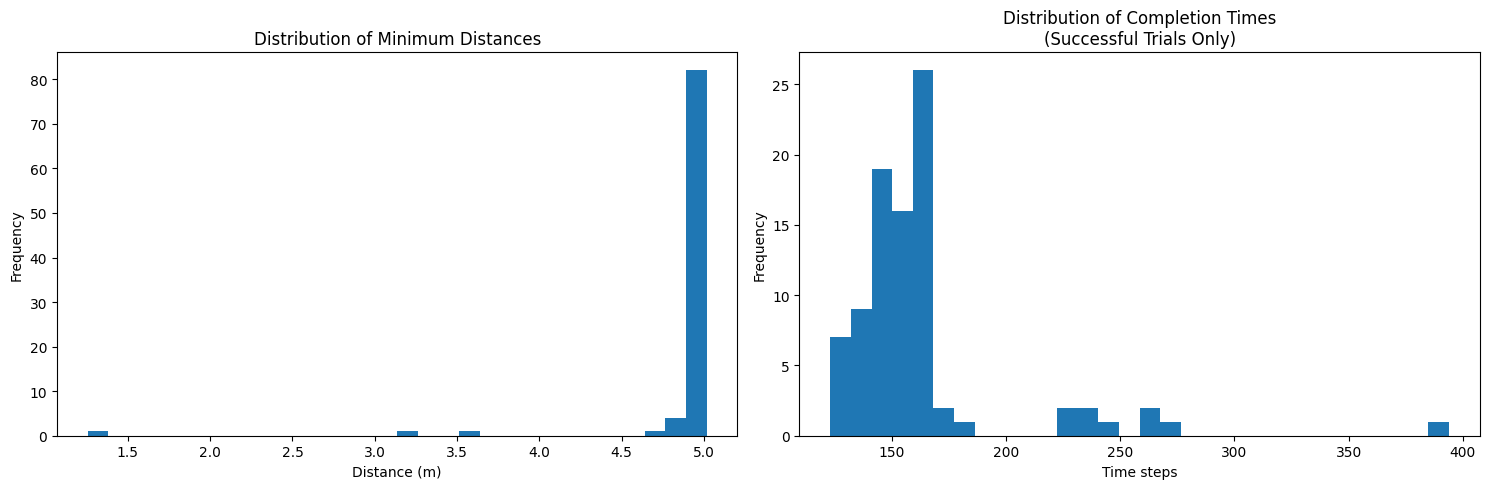

Monte Carlo Simulation Results (100 trials):
Success Rate: 89.00%
Average Minimum Distance: 4.91 m
Std Dev of Minimum Distance: 0.46 m
Average Completion Time (successful trials): 163.13 steps


In [ ]:
# Run Monte Carlo analysis with 100 trials
trails = 100
analyze_monte_carlo_results(run_monte_carlo_simulation(trails,Param_SV, Param_EV),trails)

In [ ]:
def generate_random_initial_state(x_range, y_range, phi_range, v_range, a_range):
    """Generate random initial state within specified ranges
    
    Args:
        x_range (tuple): (min, max) range for x position
        y_range (tuple): (min, max) range for y position 
        phi_range (tuple): (min, max) range for heading angle
        v_range (tuple): (min, max) range for velocity
        a_range (tuple): (min, max) range for acceleration
        
    Returns:
        np.array: Random initial state [x, y, phi, v, a]
    """
    return np.array([
        np.random.uniform(*x_range),    # x position
        np.random.uniform(*y_range),    # y position
        np.random.uniform(*phi_range),  # heading angle
        np.random.uniform(*v_range),    # velocity
        np.random.uniform(*a_range)     # acceleration
    ])

def run_monte_carlo_simulation(num_trials, Param_SV, Param_EV):
    # Store results for each trial
    results = {
        'success_count': 0,  # Count of successful arrivals
        'min_distances': [],
        'completion_times': [],
        'trajectories_SV': [],
        'trajectories_EV': [],
        'failed_trials': 0  # Add counter for failed trials
    }
    
    # Add progress bar
    pbar = tqdm(range(num_trials), desc='Running Monte Carlo Trials')
    
    for trial in pbar:
        try:
            # Randomize initial conditions
            # For SV (Subject Vehicle)
            SV_initial = generate_random_initial_state(
                x_range=(60, 80),      # Starting further back
                y_range=(1, 5),        # Within road bounds
                phi_range=(3.0, 3.28), # Roughly pointing left
                v_range=(0.8, 1.2),    # Around 1 m/s
                a_range=(-0.1, 0.1)    # Small initial acceleration
            )

            # For EV (Ego Vehicle) 
            EV_initial = generate_random_initial_state(
                x_range=(20, 40),      # Starting in middle
                y_range=(1, 5),        # Within road bounds
                phi_range=(0.05,0.2),  # Roughly pointing right
                v_range=(0.8, 1.2),    # Around 1 m/s
                a_range=(-0.1, 0.1)    # Small initial acceleration
            )

            # Run single simulation
            trial_results = run_single_simulation(SV_initial, EV_initial, Param_SV, Param_EV)
            
            # Store results
            results['min_distances'].append(trial_results['min_distance'])
            results['completion_times'].append(trial_results['completion_time'])
            results['trajectories_SV'].append(trial_results['trajectory_SV'])
            results['trajectories_EV'].append(trial_results['trajectory_EV'])
            
            if trial_results['success']:
                results['success_count'] += 1
                
        except Exception as e:
            results['failed_trials'] += 1
            print(f"\nTrial {trial} failed with error: {str(e)}")
            continue
            
        # Update progress bar with success rate and failure count
        pbar.set_postfix({
            'Success Rate': f"{(results['success_count']/(trial+1))*100:.1f}%",
            'Failed Trials': results['failed_trials']
        })
            
    return results

def run_single_simulation(SV_initial, EV_initial, Param_SV, Param_EV):
    """Run a single simulation with given initial conditions"""
    SV = SV_controller(Param_SV)
    State_SV_R = np.zeros((5, simulation_time+1))
    State_SV_R[:, 0] = SV_initial
    
    EV = SV_controller(Param_EV)
    State_EV_R = np.zeros((5, simulation_time+1))
    State_EV_R[:, 0] = EV_initial
    
    min_distance = float('inf')
    success = False
    completion_time = simulation_time
    
    # Define goal positions and tolerance
    goal_SV = Param_SV["RefPos"]
    goal_EV = Param_EV["RefPos"]
    position_tolerance = 5.0  # meters
    velocity_tolerance = 0.5  # m/s
    heading_tolerance = 0.1   # radians
    
    for i in range(simulation_time):
        SV_phi = State_SV_R[2, i]
        SV_acc = np.array([State_SV_R[4, i]*np.cos(SV_phi), State_SV_R[4, i]*np.sin(SV_phi)])
        SV_pos = np.array([State_SV_R[0, i], State_SV_R[1, i]])
        SV_vel = np.array([State_SV_R[3, i]*np.cos(SV_phi), State_SV_R[3, i]*np.sin(SV_phi)])
        
        EV_phi = State_EV_R[2, i]
        EV_acc = np.array([State_EV_R[4, i]*np.cos(EV_phi), State_EV_R[4, i]*np.sin(EV_phi)])
        EV_pos = np.array([State_EV_R[0, i], State_EV_R[1, i]])
        EV_vel = np.array([State_EV_R[3, i]*np.cos(EV_phi), State_EV_R[3, i]*np.sin(EV_phi)])
        
        # Calculate distance between vehicles
        distance = np.linalg.norm(EV_pos - SV_pos)
        min_distance = min(min_distance, distance)
        
        # Check if both vehicles have reached their goals
        SV_at_goal = (np.linalg.norm(SV_pos - goal_SV[0:2]) < position_tolerance)
        #print("SV_goal:", np.linalg.norm(SV_pos - goal_SV[0:2]) - position_tolerance)
        EV_at_goal = (np.linalg.norm(EV_pos - goal_EV[0:2]) < position_tolerance)
        #print("EV_goal:", np.linalg.norm(EV_pos - goal_EV[0:2]) - position_tolerance)
        
        if SV_at_goal and EV_at_goal:
            success = True
            completion_time = i
            break
            
        # Update states
        U_R_SV, trajectory_planning_k_SV, _, _, _ = SV.Return(
            EV_acc.reshape(2,1), EV_pos.reshape(2,1), EV_vel.reshape(2,1), EV_phi, State_SV_R[:, i]
        )
        U_R_EV, trajectory_planning_k_EV, _, _, _ = EV.Return(
            SV_acc.reshape(2,1), SV_pos.reshape(2,1), SV_vel.reshape(2,1), SV_phi, State_EV_R[:, i]
        )
        
        State_SV_R[:, i + 1] = trajectory_planning_k_SV[:, 1]
        State_EV_R[:, i + 1] = trajectory_planning_k_EV[:, 1]
    
    return {
        'success': success,
        'min_distance': min_distance,
        'completion_time': completion_time,
        'trajectory_SV': State_SV_R,
        'trajectory_EV': State_EV_R
    }

def analyze_monte_carlo_results(results, num_trials):
    """Analyze and visualize Monte Carlo simulation results"""
    # Calculate statistics
    success_rate = results['success_count'] / num_trials * 100
    avg_min_distance = np.mean(results['min_distances'])
    std_min_distance = np.std(results['min_distances'])
    avg_completion_time = np.mean([t for t in results['completion_times'] if t < simulation_time])
    
    # Plot histograms
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.hist(results['min_distances'], bins=30)
    ax1.set_title('Distribution of Minimum Distances')
    ax1.set_xlabel('Distance (m)')
    ax1.set_ylabel('Frequency')
    
    completion_times = [t for t in results['completion_times'] if t < simulation_time]
    if completion_times:
        ax2.hist(completion_times, bins=30)
        ax2.set_title('Distribution of Completion Times\n(Successful Trials Only)')
        ax2.set_xlabel('Time steps')
        ax2.set_ylabel('Frequency')
    else:
        ax2.text(0.5, 0.5, 'No successful completions', ha='center', va='center')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"Monte Carlo Simulation Results ({num_trials} trials):")
    print(f"Success Rate: {success_rate:.2f}%")
    print(f"Average Minimum Distance: {avg_min_distance:.2f} m")
    print(f"Std Dev of Minimum Distance: {std_min_distance:.2f} m")
    if completion_times:
        print(f"Average Completion Time (successful trials): {avg_completion_time:.2f} steps")
    else:
        print("No successful completions")

Running Monte Carlo Trials:   8%|▊         | 8/100 [14:52<2:48:10, 109.68s/it, Success Rate=0.0%, Failed Trials=0]


Trial 7 failed with error: QH6347 qhull precision error (qh_mergefacet): wide merge for facet f3056 into f223 for mergetype 10 (degen).  maxdist  0 (0.0x) mindist -0.043 (193004853608.0x) vertexdist 0.4  Allow with 'Q12' (allow-wide)
ERRONEOUS FACET:
- f3056
    - flags: top newfacet mergeridge1 newmerge
    - merges: 3
    - normal:  -1.849e-16 1.002e-16  -0.4706   0.8824
    - offset:  0.4464763
    - vertices: p1218(v198) p1262(v88) p277(v38) p290(v25) p976(v12)
    - neighboring facets: f223
    - ridges:
     - r1054 tested simplicialtop
           vertices: p1262(v88) p277(v38) p976(v12)
           between f3056 and f223
     - r252
           vertices: p277(v38) p290(v25) p976(v12)
           between f3056 and f223
     - r1044 simplicialtop
           vertices: p1262(v88) p277(v38) p290(v25)
           between f223 and f3056
     - r273
           vertices: p1262(v88) p290(v25) p976(v12)
           between f223 and f3056
ERRONEOUS OTHER FACET:
- f223
    - flags: bottom tested

Running Monte Carlo Trials:  50%|█████     | 50/100 [1:27:07<1:04:29, 77.38s/it, Success Rate=6.1%, Failed Trials=1] 


Trial 49 failed with error: QH6347 qhull precision error (qh_mergefacet): wide merge for facet f1605 into f360 for mergetype 10 (degen).  maxdist  0 (0.0x) mindist -0.79 (1012824503480.7x) vertexdist 0.68  Allow with 'Q12' (allow-wide)
ERRONEOUS FACET:
- f1605
    - flags: bottom newfacet mergeridge1 newmerge
    - merges: 3
    - normal:    0.4258  -0.9048 -1.837e-16 1.226e-17
    - offset:  -27.93592
    - vertices: p1020(v150) p696(v116) p937(v114) p941(v98) p675(v1)
    - neighboring facets: f360
    - ridges:
     - r1434 tested simplicialtop simplicialbot
           vertices: p696(v116) p937(v114) p675(v1)
           between f360 and f1605
     - r1394
           vertices: p937(v114) p941(v98) p675(v1)
           between f360 and f1605
     - r1436
           vertices: p696(v116) p937(v114) p941(v98)
           between f1605 and f360
     - r1175
           vertices: p696(v116) p941(v98) p675(v1)
           between f1605 and f360
ERRONEOUS OTHER FACET:
- f360
    - flags: bottom

Running Monte Carlo Trials:  97%|█████████▋| 97/100 [2:41:35<03:29, 69.89s/it, Success Rate=10.4%, Failed Trials=2]  


Trial 96 failed with error: QH6347 qhull precision error (qh_mergefacet): wide merge for facet f4675 into f2902 for mergetype 10 (degen).  maxdist  0 (0.0x) mindist -0.12 (215794111052.0x) vertexdist 0.4  Allow with 'Q12' (allow-wide)
ERRONEOUS FACET:
- f4675
    - flags: bottom newfacet mergeridge1 newmerge
    - merges: 3
    - normal:    0.9363  -0.3511 -3.149e-17 3.354e-17
    - offset:  -40.57397
    - vertices: p729(v380) p1220(v134) p895(v99) p896(v70) p1216(v42)
    - neighboring facets: f2902
    - ridges:
     - r1882 tested simplicialbot
           vertices: p1220(v134) p895(v99) p1216(v42)
           between f2902 and f4675
     - r1256
           vertices: p895(v99) p896(v70) p1216(v42)
           between f2902 and f4675
     - r1878
           vertices: p1220(v134) p895(v99) p896(v70)
           between f4675 and f2902
     - r727
           vertices: p1220(v134) p896(v70) p1216(v42)
           between f4675 and f2902
ERRONEOUS OTHER FACET:
- f2902
    - flags: top teste

Running Monte Carlo Trials: 100%|██████████| 100/100 [2:47:00<00:00, 100.21s/it, Success Rate=10.0%, Failed Trials=3]


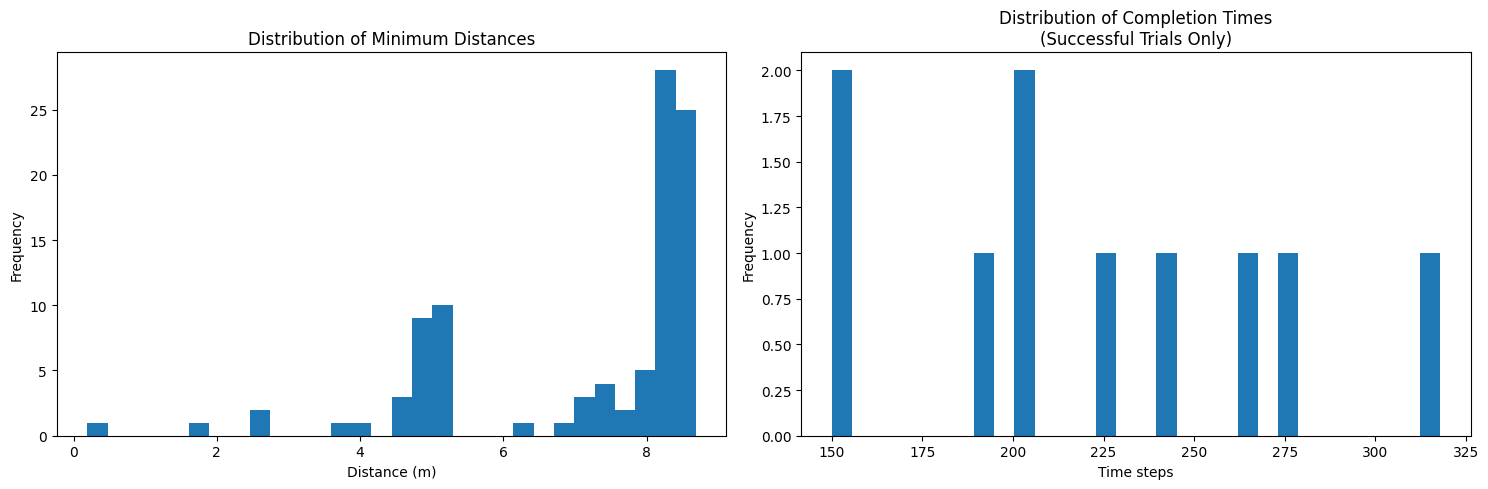

Monte Carlo Simulation Results (100 trials):
Success Rate: 10.00%
Average Minimum Distance: 7.10 m
Std Dev of Minimum Distance: 1.86 m
Average Completion Time (successful trials): 223.00 steps


In [ ]:
# Run Monte Carlo analysis with 100 trials
trails = 100
analyze_monte_carlo_results(run_monte_carlo_simulation(trails,Param_SV, Param_EV),trails)